# Word Embedding - Home Assigment
## Dr. Omri Allouche 2021. YData Deep Learning Course

[Open in Google Colab](https://colab.research.google.com/github/omriallouche/ydata_deep_learning_2021/blob/master/assignments/word_vectors_text_classification/DL_word_embedding_assignment.ipynb)

    
In this exercise, you'll use word vectors trained on a corpus of lyrics of songs from MetroLyrics ([http://github.com/omriallouche/ydata_deep_learning_2021/blob/master/data/metrolyrics.parquet](/data/metrolyrics.parquet)).
The dataset contains these fields for each song, in CSV format:
1. index
1. song
1. year
1. artist
1. genre
1. lyrics

Before doing this exercise, we recommend that you go over the "Bag of words meets bag of popcorn" tutorial (https://www.kaggle.com/c/word2vec-nlp-tutorial)

Other recommended resources:
- https://rare-technologies.com/word2vec-tutorial/
- https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

## Preparation

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import FunctionTransformer

from xgboost import XGBRegressor, XGBClassifier

from gensim.models import word2vec
from gensim.parsing.preprocessing import remove_stopwords

import copy
import logging
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch
import torch.optim as optim
from torch.optim import lr_scheduler

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
sns.set_style("darkgrid")

### Load the data & EDA


In [2]:
# download and load the data
url = 'http://github.com/omriallouche/ydata_deep_learning_2021/blob/master/data/metrolyrics.parquet?raw=true'
songs_df = pd.read_parquet(url)

In [3]:
# EDA
songs_df.head(2)

,song,year,artist,genre,lyrics,num_chars,sent,num_words
204182,fully-dressed,2008,annie,Pop,[HEALY]\n[spoken] This is Bert Healy saying .....,1041,healy spoken this bert healy saying singing he...,826
6116,surrounded-by-hoes,2006,50-cent,Hip-Hop,[Chorus: repeat 2X] Even when I'm tryin to be ...,1392,chorus repeat x even i tryin low i recognized ...,884


In [4]:
songs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49976 entries, 204182 to 11180
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   song       49976 non-null  object
 1   year       49976 non-null  int64 
 2   artist     49976 non-null  object
 3   genre      49976 non-null  object
 4   lyrics     49976 non-null  object
 5   num_chars  49976 non-null  int64 
 6   sent       49976 non-null  object
 7   num_words  49976 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 3.4+ MB


In [5]:
songs_df.loc[204182].lyrics

"[HEALY]\n[spoken] This is Bert Healy saying ...\n[singing now] Hey, hobo man\nHey, Dapper Dan\nYou've both got your style\nBut Brother,\nYou're never fully dressed\nWithout a smile!\nYour clothes may be Beau Brummelly\nThey stand out a mile --\nBut Brother,\nYou're never fully dressed\nWithout a smile!\nWho cares what they're wearing\nOn Main Street,\nOr Saville Row,\nIt's what you wear from ear to ear\nAnd not from head to toe\n(That matters)\nSo, Senator,\nSo, Janitor,\nSo long for a while\nRemember,\nYou're never fully dressed\nWithout a smile!\n[BOYLAN SISTER]\nReady or not, here he goes\nListen to Bert\nTap his smilin' toes\n[HEALY]\n[spoken] Ah, the lovely Boylan Sisters\n[BOYLAN SISTERS]\nDoo doodle-oo doo\nDoo doodle-oo doo\nDoo doo doo doo\nDoo doo doo doo\nYour clothes may be Beau Brummelly\nThey stand out a mile\nBut, bother\nYou're never fully dressed\nYou're never dressed\nWithout an\n[CONNIE BOYLAN]\nS-\n[BONNIE BOYLAN]\nM-\n[RONNIE BOYLAN]\nI-\n[CONNIE BOYLAN]\nL-\n[ALL

In [6]:
songs_df.loc[204182].sent

'healy spoken this bert healy saying singing hey hobo man hey dapper dan you got style but brother you never fully dressed without smile your clothes may beau brummelly they stand mile but brother you never fully dressed without smile who cares wearing on main street or saville row it wear ear ear and head toe that matters so senator so janitor so long remember you never fully dressed without smile boylan sister ready goes listen bert tap smilin toes healy spoken ah lovely boylan sisters boylan sisters doo doodle oo doo doo doodle oo doo doo doo doo doo doo doo doo doo your clothes may beau brummelly they stand mile but bother you never fully dressed you never dressed without connie boylan s bonnie boylan m ronnie boylan i connie boylan l all three e smile darn ya smile all that matters so senator so janitor so long'

It seems that the **sent** column contains the pre-processed text: lowercased, removed special characters, removed stop words etc.

**Num_words** column contains the length of the sent column, in characters.

### Train word vectors
Train word vectors using the Skipgram Word2vec algorithm and the gensim package.
Make sure you perform the following:
- Tokenize words
- Lowercase all words
- Remove punctuation marks
- Remove rare words
- Remove stopwords

Use 300 as the dimension of the word vectors. Try different context sizes.

In [7]:
# most of the above tasks are already done in 'sent' column of the dataframe

# remove stopwords
clean_sentences = [remove_stopwords(song) for song in songs_df.sent]
clean_sentences[0]

'healy spoken bert healy saying singing hey hobo man hey dapper dan got style brother fully dressed smile clothes beau brummelly stand mile brother fully dressed smile cares wearing main street saville row wear ear ear head toe matters senator janitor long remember fully dressed smile boylan sister ready goes listen bert tap smilin toes healy spoken ah lovely boylan sisters boylan sisters doo doodle oo doo doo doodle oo doo doo doo doo doo doo doo doo doo clothes beau brummelly stand mile bother fully dressed dressed connie boylan s bonnie boylan m ronnie boylan connie boylan l e smile darn ya smile matters senator janitor long'

In [8]:
# here we convert the sentences into list of (lists of tokens)
tokenized_text = [raw_sentence.split() for raw_sentence in clean_sentences]
print('First 10 tokens', tokenized_text[0][:10])

First 10 tokens ['healy', 'spoken', 'bert', 'healy', 'saying', 'singing', 'hey', 'hobo', 'man', 'hey']


In [9]:
# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',level=logging.INFO)

# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 10   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 5           # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (we will only do it on the first run)

word2vec_model = word2vec.Word2Vec(tokenized_text, workers=num_workers, size=num_features, min_count = min_word_count, window = context, sample = downsampling, iter=5)

# If you don't plan to train the model any further, calling init_sims will make the model much more memory-efficient.
word2vec_model.init_sims(replace=True)

2021-04-10 07:27:28,239 : INFO : collecting all words and their counts
2021-04-10 07:27:28,244 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-04-10 07:27:28,495 : INFO : PROGRESS: at sentence #10000, processed 1210335 words, keeping 66509 word types
2021-04-10 07:27:28,770 : INFO : PROGRESS: at sentence #20000, processed 2421461 words, keeping 99882 word types
2021-04-10 07:27:29,035 : INFO : PROGRESS: at sentence #30000, processed 3649026 words, keeping 127228 word types
2021-04-10 07:27:29,325 : INFO : PROGRESS: at sentence #40000, processed 4860798 words, keeping 150309 word types
2021-04-10 07:27:29,626 : INFO : collected 170189 word types from a corpus of 6080186 raw words and 49976 sentences
2021-04-10 07:27:29,627 : INFO : Loading a fresh vocabulary
2021-04-10 07:27:29,976 : INFO : effective_min_count=10 retains 28325 unique words (16% of original 170189, drops 141864)
2021-04-10 07:27:29,986 : INFO : effective_min_count=10 leaves 5776329 word co

### Review most similar words
Get initial evaluation of the word vectors by analyzing the most similar words for a few interesting words in the text. 

Choose words yourself, and find the most similar words to them.

In [10]:
word2vec_model.wv.most_similar("man")

[('woman', 0.6332130432128906),
 ('plan', 0.569317102432251),
 ('understand', 0.5401921272277832),
 ('gamblin', 0.4869733452796936),
 ('beenie', 0.4457629323005676),
 ('fellow', 0.44421106576919556),
 ('mans', 0.4356945753097534),
 ('understands', 0.427226185798645),
 ('wealthy', 0.4197186827659607),
 ('fam', 0.41852810978889465)]

In [11]:
word2vec_model.wv.most_similar("love")

[('affair', 0.6024057865142822),
 ('darling', 0.5997490882873535),
 ('babe', 0.5896870493888855),
 ('darlin', 0.5818769931793213),
 ('unconditional', 0.5628246068954468),
 ('tender', 0.5507088899612427),
 ('loving', 0.5470552444458008),
 ('heartaches', 0.5340626239776611),
 ('baby', 0.5290589928627014),
 ('satisfied', 0.5274744033813477)]

In [12]:
word2vec_model.wv.most_similar("kiss")

[('goodnight', 0.6999824643135071),
 ('lips', 0.6838077306747437),
 ('hug', 0.6629210710525513),
 ('kissed', 0.6403269171714783),
 ('kisses', 0.619562566280365),
 ('cheek', 0.5925288200378418),
 ('touch', 0.5487626194953918),
 ('fingertips', 0.5445724725723267),
 ('goodbye', 0.5361193418502808),
 ('miss', 0.5303822159767151)]

### Word Vectors Algebra
We've seen in class examples of algebraic games on the word vectors (e.g. man - woman + king = queen ). 

Try a few vector algebra terms, and evaluate how well they work. Try to use the Cosine distance and compare it to the Euclidean distance.

In [13]:
terms = ['man', 'woman', 'king', 'queen']
man_vec, woman_vec, king_vec, queen_vec = [word2vec_model.wv[term] for term in terms]
calc_queen_vec = man_vec - woman_vec + king_vec

In [14]:
# let's compare the first 10 dimensions of the real and calculated queen vectors
list(zip(queen_vec[:10], calc_queen_vec[:10]))

[(-0.012156274, -0.032186512),
 (0.040986914, 0.08903932),
 (-0.04327172, -0.06712454),
 (0.05270426, 0.009033363),
 (-0.09603879, -0.13335544),
 (0.009986565, 0.018041275),
 (-0.06878846, -0.029321395),
 (0.055007234, -0.16258904),
 (0.09157591, 0.053189233),
 (0.04846121, -0.007218517)]

We can see that some dimensions are very close, while others are quite different.

Now, let's compare cosine similarity of these two terms to similiary to other terms. Cosine distance is preferred to be used with word vectors and it's the default in Gensim word2vec.

In [15]:
cosine_sim = word2vec_model.wv.cosine_similarities(queen_vec, [man_vec, woman_vec, king_vec, queen_vec, calc_queen_vec])
all_terms = [*terms, 'calculated queen vector']
print('Cosine similarity of queen word vector to below 5 word vectors:')
pd.Series(cosine_sim, all_terms).sort_values(ascending=False) 

Cosine similarity of queen word vector to below 5 word vectors:


queen                      1.000000
king                       0.684490
calculated queen vector    0.388633
woman                      0.355576
man                        0.177129
dtype: float32

**Using cosine similarity**: We can see that queen word vector is close to itself (similarity 1, obviously) and to king (similarity 0.63), but less close to calculated queen vector we have constructed (similarity 0.33)

In [16]:
euc_dict = {}
print('Euclidian distance of queen word vector to below 5 word vectors:')
for i, vec in enumerate([man_vec, woman_vec, king_vec, queen_vec, calc_queen_vec]):
  euc_dict[all_terms[i]] = np.linalg.norm(vec - queen_vec)
pd.Series(euc_dict).sort_values()   

Euclidian distance of queen word vector to below 5 word vectors:


queen                      0.000000
king                       0.794368
woman                      1.135274
man                        1.282864
calculated queen vector    1.297462
dtype: float64

**Using euclidian distance**: Obviously, we can see that queen word vector is close to itself (distance 0) and to king (distance 0.85), but less close to calculated queen vector we have constructed (distance 1.4).

## Sentiment Analysis
Estimate sentiment of words using word vectors.  
In this section, we'll use the SemEval-2015 English Twitter Sentiment Lexicon.  
The lexicon was used as an official test set in the SemEval-2015 shared Task #10: Subtask E, and contains a polarity score for words in range -1 (negative) to 1 (positive) - http://saifmohammad.com/WebPages/SCL.html#OPP

### Load & Preprocess Data

In [17]:
# load the sentiment analysis data file into a dataframe
resp = urlopen("http://saifmohammad.com/WebDocs/lexiconstoreleaseonsclpage/SemEval2015-English-Twitter-Lexicon.zip")
zipfile = ZipFile(BytesIO(resp.read()))
this_zip_file = zipfile.open('SemEval2015-English-Twitter-Lexicon/SemEval2015-English-Twitter-Lexicon.txt')
sentiment_df = pd.read_csv(this_zip_file, sep='\t',names=['score','term'])
sentiment_df.head()

,score,term
0,0.984,loves
1,0.984,#inspirational
2,0.969,amazing
3,0.969,#peaceful
4,0.953,#greatness


In [18]:
!mkdir data # this will hold the zip file and the extracted files

mkdir: cannot create directory ‘data’: File exists


In [19]:
resp = urlopen("http://saifmohammad.com/WebDocs/lexiconstoreleaseonsclpage/SemEval2015-English-Twitter-Lexicon.zip")
zipfile = ZipFile(BytesIO(resp.read())) # download the file
zipfile.extractall(path='./data/') # Extract all the contents of zip file to ./data/ folder
sentiment_df = pd.read_csv('./data/SemEval2015-English-Twitter-Lexicon/SemEval2015-English-Twitter-Lexicon.txt', sep='\t',names=['score','term'])
sentiment_df.term = sentiment_df.term.replace("#","", regex=True)   # remove hashtags

f = open('./data/SemEval2015-English-Twitter-Lexicon/SemEval2015-English-negators.txt')           # Open a file for reading
negator_list = f.readlines()                # reads all the lines in the file into a list of strings
negator_list = [word.strip().lower() for word in negator_list]

# handle negatives (remove them and change score sign)
def starts_with_negator(text):
  if len(text)==0:
    return False
  if text.split()[0] in negator_list:
    return True
  return False

def remove_first_word(text):
  return ' '.join((text.split()[1:]))

negator_mask = sentiment_df.term.apply(starts_with_negator)
sentiment_df.loc[negator_mask, 'score'] = sentiment_df.score * (-1) # change score sign 
sentiment_df.loc[negator_mask, 'term'] = sentiment_df.term.apply(remove_first_word) # remove the negator terms

2021-04-10 07:28:33,070 : INFO : NumExpr defaulting to 2 threads.


In [20]:
sentiment_df.head()

,score,term
0,0.984,loves
1,0.984,inspirational
2,0.969,amazing
3,0.969,peaceful
4,0.953,greatness


Build a regressor for the sentiment of a word given its word vector, in range -1 to 1. 

Split the data to a train and test sets, and report the model performance on both sets.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(sentiment_df.term, sentiment_df.score, test_size=0.2, random_state=42) # 80% / 20% split

### Neural Model

In [22]:
# decoder function: convert each sample in X_train and X_test into a list of tokens, then apply word2vec on each token, and then return the average of each term

# function to tokenize a string, apply word2vec on each token, and return the average of each term
def vectorize_term(term):
  token_vectors = []
  for token in term.split():
    if token in word2vec_model.wv.vocab: # only if the token is in vocabulary
      token_vectors.append(word2vec_model.wv[token])
  
  # Handle an edge case when all tokens in the term are Out-of_vocabulary in our trained Word2Vec model: return a zero vector
  if len(token_vectors)==0: 
    return np.zeros(300)
  
  return np.array(token_vectors).mean(axis=0) # return one vector that is the mean of all the word vectors in the term

In [23]:
# build a custom dataset

class CustomDataset(Dataset):
    def __init__(self, texts, labels, vectorizer_function):
        self.labels = labels
        self.texts = texts
        self.vectorizer = vectorizer_function

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        vec = self.vectorizer(text)
        sample = {"embedding": vec, "label": label}
        return sample

In [24]:
# create the datasets and dataloaders
train_dataset = CustomDataset(X_train, y_train, vectorize_term)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = CustomDataset(X_test, y_test, vectorize_term)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [25]:
hidden = 64 # neurons in hidden layer

regression_model = nn.Sequential(
    nn.Linear(300, hidden), # 300 inputs (dimension of word2vec embedding)
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(hidden, 1) # Output layer - 1 neuron for regression task
  )

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

regression_model = regression_model.to(device)
print(regression_model)

Using cuda device
Sequential(
  (0): Linear(in_features=300, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=64, out_features=1, bias=True)
)


In [27]:
def train_model(model, train_dataloader, test_dataloader, criterion, optimizer, scheduler, num_epochs=15):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 999
    train_size = len(train_dataloader.dataset.labels)
    test_size = len(test_dataloader.dataset.labels)
    model = model.double()

    for epoch in range(num_epochs):

        # model training
        model.train()
        running_loss = 0.0

        for batch in train_dataloader:
            inputs = batch['embedding'].to(device).double()
            labels = batch['label'].to(device)
            labels = labels.view(-1,1) # reshape to (16,1), like model output
            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs) 
                loss = criterion(outputs, labels)
                loss.backward() 
                optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        train_epoch_loss = running_loss / train_size
        scheduler.step()  

        # model validation
        model.eval()   
        running_loss = 0.0

        for batch in test_dataloader:
            inputs = batch['embedding'].to(device).double()
            labels = batch['label'].to(device)
            labels = labels.view(-1,1) # reshape to (16,1), like model output
            optimizer.zero_grad()

            with torch.set_grad_enabled(False):
                outputs = model(inputs) 
                loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
        test_epoch_loss = running_loss / test_size

        # Print epoch stats
        print(f'Epoch\t {epoch} Train Loss\t {train_epoch_loss:.4f} Test Loss\t {test_epoch_loss:.4f}')       
        
        # Save the best model
        if test_epoch_loss < best_loss:
            best_loss = test_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
    
    # Complete training
    print(f'Training complete. Best test loss: {best_loss:4f}')
    model.load_state_dict(best_model_wts) # return model to the best state

In [28]:
# train the model
optimizer = optim.Adam(regression_model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
criterion = nn.MSELoss()
train_model(regression_model, train_dataloader, test_dataloader, criterion, optimizer, exp_lr_scheduler)

Epoch	 0 Train Loss	 0.2317 Test Loss	 0.1975
Epoch	 1 Train Loss	 0.1901 Test Loss	 0.1744
Epoch	 2 Train Loss	 0.1731 Test Loss	 0.1671
Epoch	 3 Train Loss	 0.1640 Test Loss	 0.1652
Epoch	 4 Train Loss	 0.1609 Test Loss	 0.1654
Epoch	 5 Train Loss	 0.1538 Test Loss	 0.1643
Epoch	 6 Train Loss	 0.1514 Test Loss	 0.1638
Epoch	 7 Train Loss	 0.1539 Test Loss	 0.1631
Epoch	 8 Train Loss	 0.1520 Test Loss	 0.1629
Epoch	 9 Train Loss	 0.1527 Test Loss	 0.1628
Epoch	 10 Train Loss	 0.1532 Test Loss	 0.1628
Epoch	 11 Train Loss	 0.1502 Test Loss	 0.1627
Epoch	 12 Train Loss	 0.1515 Test Loss	 0.1627
Epoch	 13 Train Loss	 0.1500 Test Loss	 0.1626
Epoch	 14 Train Loss	 0.1507 Test Loss	 0.1626
Training complete. Best test loss: 0.162626


In [29]:
# manual evaluation on one batch
batch = next(iter(test_dataloader))
inputs = batch['embedding'].to(device).double()
labels = batch['label'].to(device)
print('Predictions & labels for the first 10 samples:')
compare_df = pd.DataFrame(zip(regression_model(inputs).view(-1).cpu().detach().numpy(), labels.cpu().detach().numpy()), columns = ['Pred','Label'])
abs_errors = abs(regression_model(inputs).view(-1)-labels).cpu().detach().numpy()
compare_df['Absolue Error'] = abs_errors
print(compare_df[:10])

print(f'\nBatch MAE {abs_errors.mean():.3f}')
print(f'Batch MSE {abs_errors.mean()**2:.3f}')

Predictions & labels for the first 10 samples:
       Pred  Label  Absolue Error
0  0.472608  0.821       0.348392
1  0.214363  0.672       0.457637
2 -0.089849 -0.859       0.769151
3  0.058186 -0.156       0.214186
4  0.542306  0.344       0.198306
5  0.058186 -0.359       0.417186
6  0.380618  0.188       0.192618
7  0.518059  0.607       0.088941
8  0.072397 -0.859       0.931397
9 -0.135903 -0.813       0.677097

Batch MAE 0.437
Batch MSE 0.191


### Other models + Evaluation

In [30]:
# XGBoost
xgbr = XGBRegressor(max_depth=4, n_estimators=100)
# vectorize the text into list of arrays (300 values in each) and then construct a dataframe with 300 columns
X_train_vectorized_df = pd.DataFrame(X_train.apply(vectorize_term).to_list()) 
X_test_vectorized_df = pd.DataFrame(X_test.apply(vectorize_term).to_list()) 
xgbr.fit(X_train_vectorized_df, y_train)

# Model Evaluation
y_train_pred = xgbr.predict(X_train_vectorized_df)
y_test_pred = xgbr.predict(X_test_vectorized_df)
print(f'Train MSE: {MSE(y_train, y_train_pred):.3f} Test MSE: {MSE(y_test, y_test_pred):.3f}')

[07:28:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train MSE: 0.074 Test MSE: 0.171


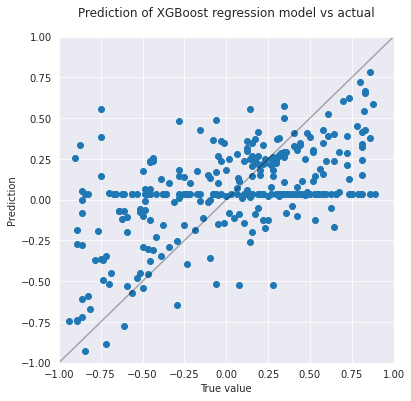

In [31]:
import matplotlib.pyplot as plt

def plot_scatter(y_pred, y, title):  
  plt.figure(figsize=(6, 6))
  plt.xlim(-1, 1)
  plt.ylim(-1, 1)
  plt.plot((-1, 1),(-1, 1), c='k', alpha=0.3)
  plt.title(title, pad=20)
  plt.ylabel('Prediction')    
  plt.xlabel('True value')
  plt.scatter(y, y_pred);

plot_scatter(y_test_pred, y_test, 'Prediction of XGBoost regression model vs actual')

In [32]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train_vectorized_df, y_train)

y_train_pred = lr.predict(X_train_vectorized_df)
y_test_pred = lr.predict(X_test_vectorized_df)
print(f'Train MSE: {MSE(y_train, y_train_pred):.3f} Test MSE: {MSE(y_test, y_test_pred):.3f}')

Train MSE: 0.132 Test MSE: 0.238


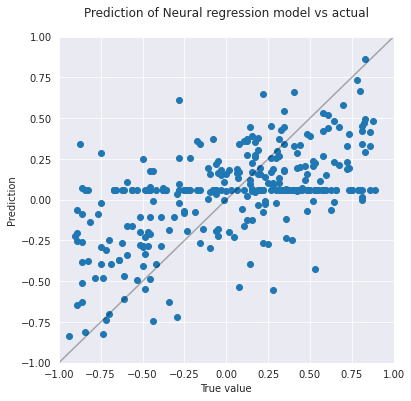

In [33]:
# Let's plot the results of the best model (Neural)

@torch.no_grad()
def predict(model, dataloader):
  model.eval()
  predictions = [] 
  for batch in dataloader:
    inputs = batch['embedding'].to(device).double()
    outputs = model(inputs) 
    predictions.append(outputs.view(-1).cpu().detach().numpy()) # append an array of batch predicitons to the list
  return np.concatenate(predictions, axis=0)

y_test_pred = predict(regression_model, test_dataloader)
plot_scatter(y_test_pred, y_test, 'Prediction of Neural regression model vs actual')

**Conclusions**:

* We can see that boall 3 models (Neural Network, XGBoost and Linear Regression) models are strongly overfitted, as train MSE in both of them is much lower than test MSE. That is expected, as we have 300 features and ~1100 training examples.
* Neural network model is a little better on test, probably because of a minimal network architecture. It has only one layer with 64 neurons, that we used specifically to reduce overfitting. Consequentially, Neural model also has the lowest delta between train and test MSE.
* Scatter plots show us that the main issue is with Out-of-Vocabulary terms, that are embedded as 0 word vector. They have all different sentiments, but all the models predict them as close to 0 (in order to minimize the MSE). It measn that if we will manage to create a better encoding with less OOV words, we will get better results.

Use your trained model from the previous question to predict the sentiment score of words in the lyrics corpus that are not part of the original sentiment dataset. Review the words with the highest positive and negative sentiment. Do the results make sense?

In [34]:
song_tokens = list(word2vec_model.wv.vocab.keys()) # get the list of all song tokens that are in our word2vec vocabulary
song_token_vectors = [word2vec_model.wv[token] for token in song_tokens] # get the corresponding list of word vectors
song_token_vectors_df = pd.DataFrame(np.vstack(song_token_vectors)) # convert song vectors into a dataframe (this is the input format for XGBoost model)
song_token_sentiment_predictions = xgbr.predict(song_token_vectors_df) # use the XGBoost model to predict the sentiment for each word vector

In [35]:
top5_idx = song_token_sentiment_predictions.argsort()[::-1][:5] # find top 5 words with positive predictions
bottom5_idx = song_token_sentiment_predictions.argsort()[:5][::-1] # find top 5 words with negative predictions
interesting_idx = np.concatenate((top5_idx, bottom5_idx))
interesting_predictions = song_token_sentiment_predictions[interesting_idx]
interesting_tokens = [song_tokens[idx] for idx in interesting_idx]
extreme_sentiments = pd.Series(data=interesting_predictions, index=interesting_tokens, name='Predicted Sentiment')
extreme_sentiments

wedded          0.990660
isle            0.928634
volare          0.878099
incomparable    0.866195
fantastic       0.864242
horrible       -0.895675
disfigured     -0.897831
disgusting     -0.928278
rape           -0.948053
stalked        -0.970689
Name: Predicted Sentiment, dtype: float32

The results mostly make sense, except for a couple of misfits.

### Visualize Word Vectors
In this section, you'll plot words on a 2D grid based on their inner similarity. We'll use the tSNE transformation to reduce dimensions from 300 to 2. You can get sample code from https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial or other tutorials online.

Perform the following:
- Keep only the 3,000 most frequent words (after removing stopwords)
- For this list, compute for each word its relative abundance in each of the genres
- Compute the ratio between the proportion of each word in each genre and the proportion of the word in the entire corpus (the background distribution)
- Pick the top 50 words for each genre. These words give good indication for that genre. Join the words from all genres into a single list of top significant words. 
- Compute tSNE transformation to 2D for all words, based on their word vectors
- Plot the list of the top significant words in 2D. Next to each word output its text. The color of each point should indicate the genre for which it is most significant.

You might prefer to use a different number of points or a slightly different methodology for improved results.  
Analyze the results.

In [36]:
# Keep only the 3,000 most frequent words (after removing stopwords)
song_tokens_count = [word2vec_model.wv.vocab[token].count for token in song_tokens]
song_tokens_count_series  = pd.Series(data=song_tokens_count, index=song_tokens)
top_3000_tokens = list(song_tokens_count_series.sort_values(ascending=False)[:3000].index)

# create dataframe with 5 genres as columns and 3K words as rows, to store the results
genres = songs_df.genre.value_counts().index
count_df = pd.DataFrame(index=top_3000_tokens, columns = genres, data=np.zeros((3000, len(genres))))

# count only the relevant tokens
cvectorizer = CountVectorizer(vocabulary=top_3000_tokens)
count_matrix = cvectorizer.fit_transform(clean_sentences).toarray() # create a 49976 x 3000 matrix with token counts for each song

# summarize the counts and frequency per genre and save it
for genre in genres:
  genre_mask = (songs_df.genre == genre) # find only records for the current genre
  token_counts = count_matrix[genre_mask,:].sum(axis=0) # sum counts in all songs of this genre
  count_df[genre] = token_counts # store the results in a relevant column in df

freq_df = count_df / count_df.sum() # create a df frequency counts

In [37]:
# Compute the ratio between the proportion of each word in each genre and the proportion of the word in the entire corpus
total_word_counts = count_df.sum(axis=1)
total_word_freqs = total_word_counts / total_word_counts.sum()
total_word_freqs_arr = total_word_freqs.values.reshape(-1, 1)
# replace zero counts to avoid division by 0
total_word_freqs_arr = np.where(total_word_freqs_arr>0, total_word_freqs_arr, np.finfo(np.float32).eps)   
relative_freq_df = freq_df / total_word_freqs_arr
relative_freq_df.head()

,Rock,Pop,Hip-Hop,Metal,Country
like,0.793375,0.853948,1.342633,0.573988,0.867105
know,1.104834,1.228291,0.978044,0.558380,0.968511
got,0.831842,0.954988,1.340829,0.346986,0.871150
love,1.060080,1.772738,0.513318,0.463523,1.696836
na,1.115282,1.449879,0.906732,0.357254,1.000657


In [38]:
# Pick the top 50 words for each genre (we assume that we use the relative frequency for this, and not regular frequency or absolute counts).
# Join the words from all genres into a single list of top significant words.

top_words = {} # dict for storing top words per ganre
for genre in genres:
  top50 = list(relative_freq_df[genre].sort_values(ascending=False).index[:50])
  print(genre, ':\n',*top50,'\n')
  top_words[genre] = top50

# list with all top words
all_top_words = [word for lst in top_words.values() for word in lst]

Rock :
 vocals pum jeg kimi ga wa bop ik tom american wasted crawling ordinary wasting desperate johnny crashing changing rum drums strangers wolf sinking bored blues doll greater sings troubles floating hiding tiny sets liar anymore het doo voc ooo dive bridges electric poison weep waited waking mistakes aching says changes 

Pop :
 nae amore coraz amor bu luna amour piel alma io nan che contigo tes sempre feliz cada pi ti tus quand rien moi mia tanto mio sentir cosa ce puede sans dolor vez puedo toi avec dentro siento mai wah qui eres dar eh cielo vie cuerpo quiero algo halo 

Hip-Hop :
 bizzy mayne eazy dre versace chamillionaire yuh pac eminem mek niggas gangsta compton wid nuttin aight rappers hella nigga niggaz trill hoes feds projects motherfuckin glock biggie rep slug kush bitches ballin thugs thug chopper dawg clique finna killa inna yall busta homies moms hustlin gat hustler rims pussy dogg 

Metal :
 corpse decay humanity chaos arise mortal existence eternal wrath mankind ag

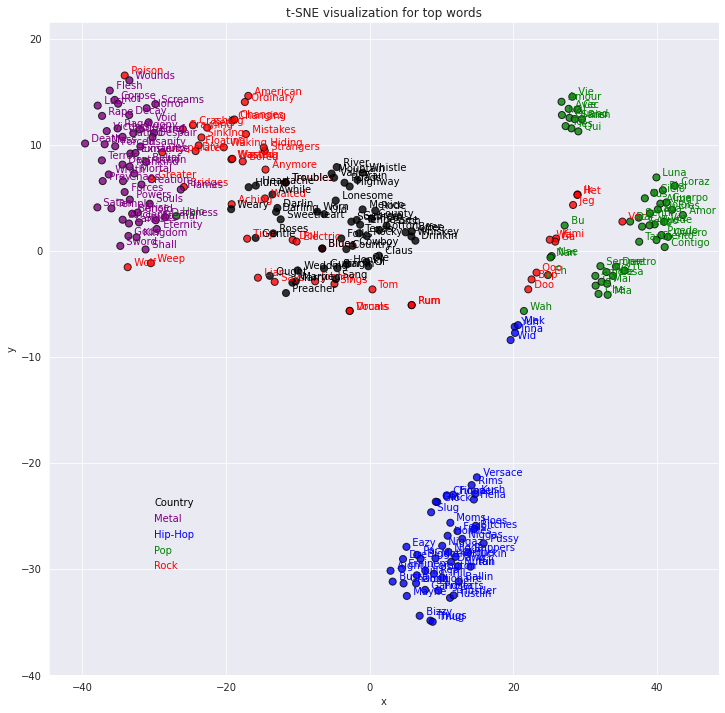

In [39]:
# Compute tSNE transformation to 2D for all words, based on their word vectors

# get a list of word vectors for all top words
all_top_words_vectors = [word2vec_model.wv[word] for word in all_top_words] 

def tsnescatterplot(word_labels, vectors, genre_names):
    # create a list of 250 colors, 50 similiar colors for each genre words
    color_list = []
    genre_colors = ['red','green','blue','purple','black']
    for color in genre_colors:
      color_list.append([color] * 50)
    color_list = [color for lst in color_list for color in lst] # flatten the list 
        
    # Reduce the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=50).fit_transform(vectors)
    
    # Find t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(12, 12)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     color = 'k',
                     scatter_kws={'s': 50, 'facecolors': df['color']}
                     )
    
   # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(10)

    plt.xlim(Y[:, 0].min()-5, Y[:, 0].max()+5)
    plt.ylim(Y[:, 1].min()-5, Y[:, 1].max()+5)
    
    # plot legend 
    for i,name in enumerate(genre_names):
        plt.text(-30, 1.5*i-30, name, color = genre_colors[i])         # parameters: x location, y location, text to write, color

    plt.title('t-SNE visualization for top words')

tsnescatterplot(all_top_words, all_top_words_vectors, genres)

**Analysis:**
* From tSNE we can clearly see that most of the words of the same genre cluster together. That is reasonable, as embedding we have learned is based on words that appear together, and of couse frequent words in a specific genre will appear together more frequently than with words from another genre.
* We can see that 2 most distinct genres are Hip-Hop and Pop, which is reasonable, as they have very distinct vocabularies. Both Country and Metal genres have some intersection with Rock, which is also reasonable (Rock and Metal have similiar historic roots).
* In additon, it also suggests that the embedding we have learned is meaninful for genre identification, that we are going to do in the next section.


## Text Classification
In this section, you'll build a text classifier, determining the genre of a song based on its lyrics.

### Text classification using Bag-of-Words
Build a Naive Bayes classifier based on the bag of Words.  
You will need to divide your dataset into a train and test sets.

Show the confusion matrix.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(songs_df.sent, songs_df.genre, test_size=0.2, random_state=42) # 80% / 20% split

nb_pipe = Pipeline([
     ('vect', CountVectorizer(max_features=10000, min_df=10, stop_words='english')),
     ('clf', MultinomialNB()),
 ])

nb_pipe.fit(X_train, y_train) # train the pipeline
print(f'Test accuracy is: {nb_pipe.score(X_test, y_test):.3f}')

Test accuracy is: 0.578


Show the confusion matrix

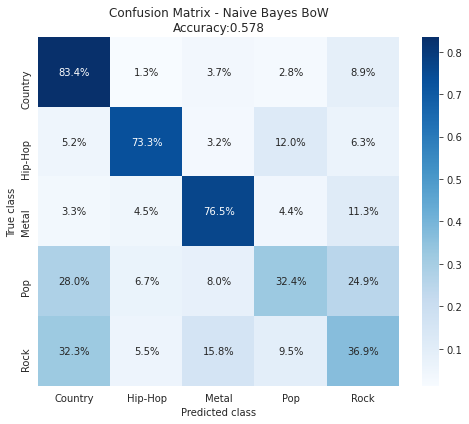

In [41]:
def draw_cm(y_test, y_pred, classes, title):
    cm = confusion_matrix(y_test, y_pred, normalize='true')                                            # calc confusion matrix
    cm_df = pd.DataFrame(cm,  index = classes, columns = classes)          # convert conf matrix array to df with class names on rows and columns
    plt.figure(figsize=(7,6))
    sns.heatmap(cm_df, annot=True, fmt = '.1%', annot_kws={"fontsize":10}, cmap='Blues')   # draw matrix as heatmap, using a small font and blue color map
    plt.title(title + '\nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))     # calc accuracy and show it in the title
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.gca().axes.tick_params(labelsize = 'medium')                                    # formating tick labels (class names)
    plt.tight_layout()

y_pred = nb_pipe.predict(X_test)
draw_cm(y_test, y_pred, nb_pipe.classes_, 'Confusion Matrix - Naive Bayes BoW')

Show the classification report - precision, recall, f1 for each class.

In [42]:
print(classification_report(y_test, y_pred, target_names=nb_pipe.classes_))

              precision    recall  f1-score   support

     Country       0.47      0.83      0.60      1656
     Hip-Hop       0.79      0.73      0.76      1917
       Metal       0.67      0.76      0.72      1828
         Pop       0.55      0.32      0.41      2214
        Rock       0.46      0.37      0.41      2381

    accuracy                           0.58      9996
   macro avg       0.59      0.61      0.58      9996
weighted avg       0.58      0.58      0.56      9996



In [46]:
# Let's try LogisticRegression with BoW, so that we'll have a reference for future assignements (that's can't use Naive Bayes because embeddings contain negative values)
from sklearn.linear_model import LogisticRegression

lr_bow_pipe = Pipeline([
     ('vect', CountVectorizer(max_features=10000, min_df=10, stop_words='english')),
     ('clf', LogisticRegression(random_state=1, max_iter=300)),
 ])

lr_bow_pipe.fit(X_train, y_train) # train the pipeline
print(f'Test accuracy is: {lr_bow_pipe.score(X_test, y_test):.3f}')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Test accuracy is: 0.573


In [ ]:
# Let's try XGBoost with BoW

xgb_bow_pipe = Pipeline([
     ('vect', CountVectorizer(max_features=10000, min_df=10, stop_words='english')),
     ('clf', XGBClassifier(max_depth=5, n_estimators=100, nthread=-1)),
 ])

xgb_bow_pipe.fit(X_train, y_train) # train the pipeline
print(f'Test accuracy is: {xgb_bow_pipe.score(X_test, y_test):.3f}')

Test accuracy is: 0.611


XGBoost result is only marginally better than Naive Bayes, but we still need XGBoost for comparison to the next section, that won't work with MultinomialNB, because it requires positive counts, while our data is word vectors, so we will be using XGBoost in the next section.

### Text classification using Word Vectors
#### Average word vectors
Do the same, using a classifier that averages the word vectors of words in the document.

In [47]:
# let's define a custom transformer, that wraps around vectorize_term function, that we have defined previously
# It tokenizes a string, applies word2vec on each token, and returns the average of each term

def mean_w2v_vectorizer(input_series):
  lst = [vectorize_term(text) for text in input_series] # create a list of vectors
  output_df = pd.DataFrame(data = np.vstack(lst), index = input_series.index)
  return output_df

transformer = FunctionTransformer(mean_w2v_vectorizer)  # wrap our function in FunctionTransformer class

lr_mean_w2v_pipe = Pipeline([
     ('vect', transformer),
     ('clf', LogisticRegression(random_state=1, max_iter=300))
 ])

lr_mean_w2v_pipe.fit(X_train, y_train) # train the pipeline
print(f'Test accuracy is: {lr_mean_w2v_pipe.score(X_test, y_test):.3f}')

Test accuracy is: 0.596


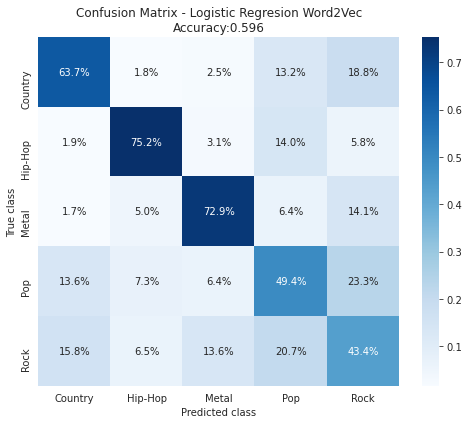

In [50]:
y_pred = lr_mean_w2v_pipe.predict(X_test)
draw_cm(y_test, y_pred, lr_mean_w2v_pipe.classes_, 'Confusion Matrix - Logistic Regresion Word2Vec')

Word2vec results are a bit better than BoW. 

#### TfIdf Weighting
Do the same, using a classifier that averages the word vectors of words in the document, weighting each word by its TfIdf.


In [51]:
# create tfidf vectorizer and train it
tfidf = TfidfVectorizer(min_df=10, max_features = 10000, stop_words = 'english')                                                    
X_train_tfidf = tfidf.fit_transform(X_train)   # Learn vocabulary and idf, return sparce term-document matrix

# create word2vec vector matrix for 10K relevant terms
token_vectors = []
for term in tfidf.get_feature_names():
    if term in word2vec_model.wv.vocab: # if the token is in vocabulary, append it
        token_vectors.append(word2vec_model.wv[term])
    else: # if the token is not in vocabulary, append a zero vector
        token_vectors.append(np.zeros(300))
word2vec_encoding_matrix = np.vstack(token_vectors)

# matrix multiplication of tfidf matrix (samples, 10K terms) and term word2vec matrix (10K terms, 300) results in (samples, 300) matrix of word vectors weighted by tfidf
X_train_tfidf_w2v = X_train_tfidf @ word2vec_encoding_matrix 

In [53]:
# create LinReg model and train it
lr_w2v_tfidf = LogisticRegression(random_state=1, max_iter=1000)
lr_w2v_tfidf.fit(X_train_tfidf_w2v, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [54]:
# inference and evaluation
X_test_tfidf = tfidf.transform(X_test) # apply trained tfidf transform on testset
X_test_tfidf_w2v = X_test_tfidf @ word2vec_encoding_matrix  # calculate average word vector weighted by tfidf
print(f'Test accuracy is: {lr_w2v_tfidf.score(X_test_tfidf_w2v, y_test):.3f}') # inference on test and compute accuracy

Test accuracy is: 0.605


Weighted average using tfidf managed to improve the accuracy by another 1 percent.

### Text classification using ConvNet
Do the same, using a ConvNet.  
The ConvNet should get as input a 2D matrix where each column is an embedding vector of a single word, and words are in order. Use zero padding so that all matrices have a similar length.  
Some songs might be very long. Trim them so you keep a maximum of 128 words (after cleaning stop words and rare words).  
Initialize the embedding layer using the word vectors that you've trained before, but allow them to change during training.  

Extra: Try training the ConvNet with 2 slight modifications:
1. freezing the the weights trained using Word2vec (preventing it from updating)
1. random initialization of the embedding layer

You are encouraged to try this question on your own.  

You might prefer to get ideas from the paper "Convolutional Neural Networks for Sentence Classification" (Kim 2014, [link](https://arxiv.org/abs/1408.5882)).

There are several implementations of the paper code in PyTorch online (see for example [this repo](https://github.com/prakashpandey9/Text-Classification-Pytorch) for a PyTorch implementation of CNN and other architectures for text classification). If you get stuck, they might provide you with a reference for your own code.

In [55]:
idx2sent = dict(enumerate(songs_df.sent))
sent2idx = {v:k for k,v in idx2sent.items()}
vector_size = word2vec_model.vector_size

In [56]:
import gensim
from sklearn.preprocessing import LabelEncoder

In [57]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [58]:
class LyricsGenreDataset(Dataset):
    def __init__(self, data: pd.DataFrame, feature_column: str, target_column: str, word2vec: gensim.models.Word2Vec, label_encoder):
        self.tokenizer = nltk.WordPunctTokenizer()

        self.data = data

        self.feature_column = feature_column
        self.target_column = target_column

        self.word2vec = word2vec.wv

        self.mean = np.mean(word2vec.wv.vectors, axis=0)
        self.std = np.std(word2vec.wv.vectors, axis=0)

        self.label_encoder = label_encoder

    def __getitem__(self, item):
        text = self.data[self.feature_column].values[item]
        if not isinstance(text, str):
            text = ""
        tokens = self.get_tokens_(text)
        embeddings = self.get_embeddings_(tokens)
        return {"features": embeddings, "targets": self.label_encoder.transform([self.data[self.target_column].values[item]])}

    def get_tokens_(self, text):
        return [lemmatizer.lemmatize(w) for w in self.tokenizer.tokenize(text.strip()) if not any(c in string.punctuation for c in w) and len(w) > 3]

    def get_embeddings_(self, tokens):
        embeddings = [(self.word2vec.get_vector(token) - self.mean) / self.std for token in tokens if
                      token in self.word2vec]

        if len(embeddings) == 0:
            embeddings = np.zeros((1, self.word2vec.vector_size))
        else:
            embeddings = np.array(embeddings)
            embeddings = np.mean(embeddings, axis=0, keepdims=True)
            if len(embeddings.shape) == 1:
                embeddings = embeddings.reshape(-1, 1)

        return embeddings

    def __len__(self):
        return self.data.shape[0]

In [59]:
class LyricsGenreDatasetTfIdf(LyricsGenreDataset):
    def __init__(self, data: pd.DataFrame, feature_column: str, target_column: str, word2vec: gensim.models.Word2Vec, labels_encoder, weights = None):
        super().__init__(data, feature_column, target_column, word2vec, labels_encoder)

        if weights is None:
            self.weights = self.get_tf_idf_()
        else:
            self.weights = weights

    def get_embeddings_(self, tokens):
        embeddings = [(self.word2vec.get_vector(token) - self.mean) / self.std  * self.weights.get(token, 1) for token in tokens if token in self.word2vec and len(token) > 3]

        if len(embeddings) == 0:
            embeddings = np.zeros((1, self.word2vec.vector_size))
        else:
            embeddings = np.array(embeddings)
            embeddings = np.mean(embeddings, axis=0, keepdims=True)
            if len(embeddings.shape) == 1:
                embeddings = embeddings.reshape(-1, 1)

        return embeddings

    def get_tf_idf_(self):
        tokenized_texts = self.data[self.feature_column].tolist()
        tf_idf = TfidfVectorizer(min_df=10, max_features = 10000, stop_words = 'english').fit(tokenized_texts)
        return dict(zip(tf_idf.get_feature_names(), tf_idf.idf_))

In [60]:
X_train, X_test, y_train, y_test = train_test_split(songs_df, songs_df.genre, test_size=0.2, random_state=42) # 80% / 20% split

In [61]:
class GenreClassifierCNN(nn.Module):
    def __init__(
        self,
        emb_dim,
        out_channels,
        kernel_sizes,
        embedding_weights,
        dropout = 0.5,
        dim = 300,
        num_classes=5,
        freeze=True
    ):
        super().__init__()

        self.embedding = nn.Embedding.from_pretrained(embedding_weights, freeze=freeze)
        self.conv_0 = nn.Conv2d(in_channels = 1, out_channels = out_channels, kernel_size = (kernel_sizes[0], dim))
        self.conv_1 = nn.Conv2d(in_channels = 1, out_channels = out_channels, kernel_size = (kernel_sizes[1], dim))
        self.conv_2 = nn.Conv2d(in_channels = 1, out_channels = out_channels, kernel_size = (kernel_sizes[2], dim))
        self.fc = nn.Linear(len(kernel_sizes) * out_channels, num_classes)
        
        self.dropout = nn.Dropout(dropout)
        self.init_weights()
        
    def forward(self, text):
        
        embedded = self.embedding(text)
        embedded = embedded.unsqueeze(1)
        
        conved_0 = F.relu(self.conv_0(embedded).squeeze(3))
        conved_1 = F.relu(self.conv_1(embedded).squeeze(3))
        conved_2 = F.relu(self.conv_2(embedded).squeeze(3))
        
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim=1))
            
        return self.fc(cat)
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

In [62]:
# create an embedding weights tensor with one additional value for Out of Vocabulary terms
vocab = list(word2vec_model.wv.vocab.keys())
word2idx = {w:idx  for idx, w in enumerate(vocab)}
OOV_TOKEN = "[OOV]"
OOV_IDX = len(vocab)
word2idx[OOV_TOKEN] = OOV_IDX
embedding_weights = torch.zeros(len(word2vec_model.wv.vectors)+1, vector_size)
embedding_weights[:-1] = torch.FloatTensor(word2vec_model.wv.vectors)
embedding_weights[-1] = torch.zeros(vector_size,)

In [82]:
MAX_LEN = 128  
dict(enumerate(songs_df.genre.unique()))

{0: 'Pop', 1: 'Hip-Hop', 2: 'Rock', 3: 'Country', 4: 'Metal'}

In [64]:
idx2cls = {0: 'Pop', 1: 'Hip-Hop', 2: 'Rock', 3: 'Country', 4: 'Metal'}
cls2idx = {idx:cls for cls, idx in idx2cls.items()}

In [65]:
class SimpleIndicesDataset(Dataset):
    def __init__(self, data: pd.DataFrame, feature_column: str, target_column: str, cls2idx, max_len=128):
        self.tokenizer = nltk.WordPunctTokenizer()
        self.data = data
        self.feature_column = feature_column
        self.target_column = target_column
        self.max_len = max_len
        self.cls2idx = cls2idx

    def __getitem__(self, item):
        text = self.data[self.feature_column].values[item]
        if not isinstance(text, str):
            text = ""
        return {"features": self.get_tokens_(text), "targets": torch.tensor([cls2idx[self.data[self.target_column].values[item]]], dtype=torch.float)}

    def get_tokens_(self, text):
        a = []
        for w in self.tokenizer.tokenize(text.strip())[:MAX_LEN]:
          if w in word2idx:
            a.append(word2idx[w])
          else:
            a.append(word2idx[OOV_TOKEN])
          ret = torch.zeros((MAX_LEN)).long()
          ret[:len(a)] = torch.tensor(a)
        return ret
        
    def __len__(self):
        return self.data.shape[0]

In [79]:
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import functional as F

train_dataset = SimpleIndicesDataset(X_train, "sent", "genre", cls2idx)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = SimpleIndicesDataset(X_test, "sent", "genre", cls2idx)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [67]:
%%capture
!pip install pytorch_lightning

#### Frozen embedding weights

In [80]:
from tqdm.autonotebook import tqdm
from pytorch_lightning import metrics

min_loss = np.inf
metric_history = {"train":[], "val":[]} 
cur_patience = 0
cnn_model = GenreClassifierCNN(emb_dim=vector_size, out_channels=64, kernel_sizes=[3, 4, 5], embedding_weights=embedding_weights, dropout=0.5).to(device)
optimizer = torch.optim.Adam(cnn_model.parameters())
max_epochs = 5
loss_func = nn.CrossEntropyLoss()
patience = 5
max_acc = 0.0
train_acc = 0.0
val_acc = 0.0

for epoch in range(1, max_epochs + 1):
    train_loss = 0.0
    train_accuracy = metrics.Accuracy().to(device)
    cnn_model.train()
    pbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    for it, batch in pbar: 
        optimizer.zero_grad()
        features = batch["features"].to(device)
        logits = F.softmax(cnn_model(features), dim=1)
        targets = batch["targets"].squeeze().long().to(device)
        batch_acc = train_accuracy(logits, targets)
        loss = loss_func(logits, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += batch_acc.item()

    train_loss /= len(train_dataloader)
    train_acc = train_accuracy.compute()
    metric_history["train"].append({"epoch": epoch,"loss":train_loss, "acc":train_acc.item()})
    
    val_loss = 0.0
    val_accuracy = metrics.Accuracy().to(device)
    cnn_model.eval()
    pbar = tqdm(enumerate(test_dataloader), total=len(test_dataloader), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    for it, batch in pbar:
        features = batch["features"].to(device)
        predictions = cnn_model(features)
        targets = batch["targets"].squeeze().long().to(device)
        logits = F.softmax(predictions, dim=1)
        batch_acc = val_accuracy(logits, targets)
        loss = loss_func(logits, targets)
        val_loss += loss.item()
        val_acc += batch_acc.item()
    
    val_loss /= len(test_dataloader)
    val_acc = val_accuracy.compute()
    metric_history["val"].append({"epoch": epoch,"loss":val_loss, "acc":val_acc.item()})
    if val_acc > max_acc:
        max_acc = val_acc
        best_model = cnn_model.state_dict()
    else:
        cur_patience += 1
        if cur_patience == patience:
            cur_patience = 0
            break
    
    print('Epoch: {}, train loss: {:.3f}, val loss: {:.3f}, train acc: {:.4f}, val acc: {:.4f}'.format(epoch, train_loss, val_loss, train_acc, val_acc))
cnn_model.load_state_dict(best_model)

Epoch: 1, train loss: 1.475, val loss: 1.423, train acc: 0.4107, val acc: 0.4701


Epoch: 2, train loss: 1.413, val loss: 1.393, train acc: 0.4807, val acc: 0.5062


Epoch: 3, train loss: 1.388, val loss: 1.372, train acc: 0.5072, val acc: 0.5243


Epoch: 4, train loss: 1.366, val loss: 1.355, train acc: 0.5321, val acc: 0.5496


Epoch: 5, train loss: 1.349, val loss: 1.348, train acc: 0.5500, val acc: 0.5517


<All keys matched successfully>

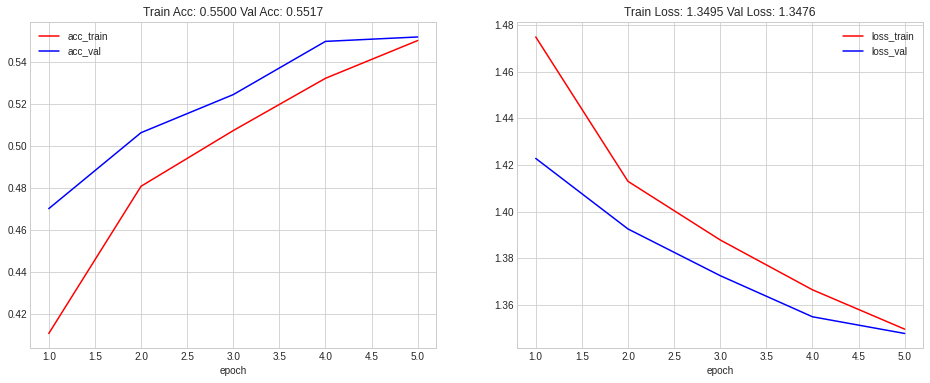

In [81]:
def plot_learning_curves(metric_history, title=""):
    with plt.style.context('seaborn-whitegrid'):
      fig,ax = plt.subplots(1,2, figsize=(16, 6))
      train_history = pd.DataFrame(metric_history["train"]).reset_index()
      val_history = pd.DataFrame(metric_history["val"]).reset_index()
      train_history.plot(x="epoch", y="acc", ax=ax[0], color="r", label="acc_train") 
      val_history.plot(x="epoch", y="acc", ax=ax[0], color="b", label="acc_val")
      train_history.plot(x="epoch", y="loss", color="r", ax=ax[1], label="loss_train")
      val_history.plot(x="epoch", y="loss", color="b", ax=ax[1], label="loss_val")
      ax[0].set_title(f'Train Acc: {train_history.iloc[-1]["acc"]:.4f} Val Acc: {val_history.iloc[-1]["acc"]:.4f}')
      ax[1].set_title(f'Train Loss: {train_history.iloc[-1]["loss"]:.4f} Val Loss: {val_history.iloc[-1]["loss"]:.4f}')
      if not title:
        fig.suptitle(title)
      plt.show();

plot_learning_curves(metric_history)

We can see that CNN trained on word vectors with frozen embedding layer. It reached accuracy of 55% on epoch 5. It would probably continue improving, if we would have more time to train and and wouldn't have to meet the due-date of exercise submission :-)

#### Unfreeze embedding weights


In [85]:
min_loss = np.inf
metric_history = {"train":[], "val":[]} 
cur_patience = 0
cnn_model = GenreClassifierCNN(emb_dim=vector_size, out_channels=64, kernel_sizes=[3, 4, 5], embedding_weights=embedding_weights, dropout=0.5, freeze=False).to(device)
optimizer = torch.optim.Adam(cnn_model.parameters())
max_epochs = 5
loss_func = nn.CrossEntropyLoss()
patience = 5
max_acc = 0.0
train_acc = 0.0
val_acc = 0.0

for epoch in range(1, max_epochs + 1):
    train_loss = 0.0
    train_accuracy = metrics.Accuracy().to(device)
    cnn_model.train()
    pbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    for it, batch in pbar: 
        optimizer.zero_grad()
        features = batch["features"].to(device)
        logits = F.softmax(cnn_model(features), dim=1)
        targets = batch["targets"].squeeze().long().to(device)
        batch_acc = train_accuracy(logits, targets)
        loss = loss_func(logits, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += batch_acc.item()

    train_loss /= len(train_dataloader)
    train_acc = train_accuracy.compute()
    metric_history["train"].append({"epoch": epoch,"loss":train_loss, "acc":train_acc.item()})
    
    val_loss = 0.0
    val_accuracy = metrics.Accuracy().to(device)
    cnn_model.eval()
    pbar = tqdm(enumerate(test_dataloader), total=len(test_dataloader), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    for it, batch in pbar:
        features = batch["features"].to(device)
        predictions = cnn_model(features)
        targets = batch["targets"].squeeze().long().to(device)
        logits = F.softmax(predictions, dim=1)
        batch_acc = val_accuracy(logits, targets)
        loss = loss_func(logits, targets)
        val_loss += loss.item()
        val_acc += batch_acc.item()
    
    val_loss /= len(test_dataloader)
    val_acc = val_accuracy.compute()
    metric_history["val"].append({"epoch": epoch,"loss":val_loss, "acc":val_acc.item()})
    if val_acc > max_acc:
        max_acc = val_acc
        best_model = cnn_model.state_dict()
    else:
        cur_patience += 1
        if cur_patience == patience:
            cur_patience = 0
            break
    
    print('Epoch: {}, train loss: {:.3f}, val loss: {:.3f}, train acc: {:.4f}, val acc: {:.4f}'.format(epoch, train_loss, val_loss, train_acc, val_acc))
cnn_model.load_state_dict(best_model)

Epoch: 1, train loss: 1.389, val loss: 1.334, train acc: 0.4990, val acc: 0.5573


Epoch: 2, train loss: 1.286, val loss: 1.314, train acc: 0.6134, val acc: 0.5803


Epoch: 3, train loss: 1.233, val loss: 1.303, train acc: 0.6672, val acc: 0.5915


Epoch: 4, train loss: 1.195, val loss: 1.307, train acc: 0.7078, val acc: 0.5881


Epoch: 5, train loss: 1.169, val loss: 1.304, train acc: 0.7337, val acc: 0.5957


<All keys matched successfully>

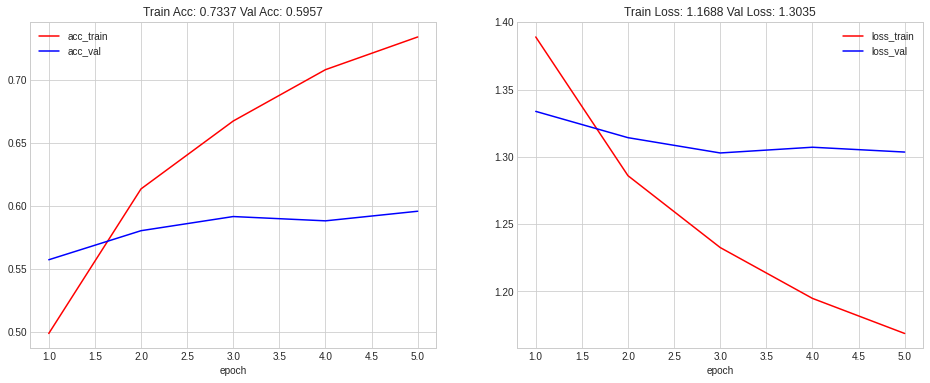

In [86]:
plot_learning_curves(metric_history)

We can see that initializing embeddings layer with our pretrained embedding vectors but letting it change during training produces much better results, as it allows the model to fine-tune it for our specific task of genre classification. This model has managed to reach the accuracy of ~60%, which is very close to our best model so far (LogReg with tf-idf weighting of our embeddings).

We think that with more time for architecture & hyperparameter tuning, we could've surpassed that result.